In [1]:
from utils.load import load_mnist
import matplotlib.pyplot as plt


torch.Size([4, 1, 4, 4]) 49


In [2]:
res = 28

In [3]:
train, test = load_mnist(64, shape_setting=[[res, 1]])

In [4]:
x = next(iter(train))[0]

In [5]:
patch_size = 4
patch_dim = 16

In [6]:
batch_size, channels, height, width = x.shape

# Divide image into patches
patches = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
patches = patches.contiguous().view(batch_size, channels, -1, patch_size**2)
patches = patches.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, patch_dim)

In [7]:
def revert_patches_to_image(patches, height, width):
    batch_size, num_patches, channels, patch_height, patch_width = patches.shape
    patches = patches.permute(0, 2, 3, 4, 1)  # [batch_size, channels, patch_height, patch_width, num_patches]
    patches = patches.contiguous().view(batch_size, channels, patch_height, patch_width, height // patch_height, width // patch_width)
    patches = patches.permute(0, 1, 4, 2, 5, 3)  # [batch_size, channels, num_patches_h, patch_height, num_patches_w, patch_width]
    image = patches.contiguous().view(batch_size, channels, height, width)
    return image

In [8]:
patches.shape

torch.Size([64, 49, 16])

In [9]:
img = revert_patches_to_image(patches.view(batch_size, -1, channels, patch_size, patch_size), res, res)

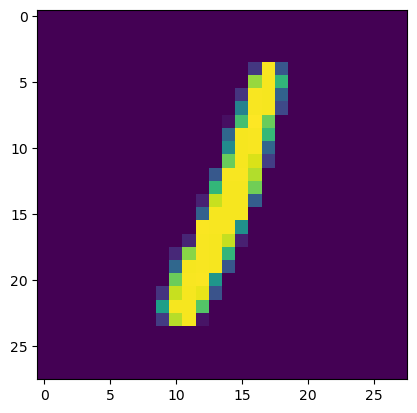

In [12]:
plt.imshow(img[2, 0])